### Week 5 - Regex

First, note that the splitting by the chapter title pattern is achieved using a **non-capturing group** `(?:...)`: 

In [2]:
import nltk.corpus
import re

moby = nltk.corpus.gutenberg.raw("melville-moby_dick.txt")

In [11]:
chapters = re.split(r"\s*(?:EXTRACTS|ETYMOLOGY\.|Epilogue|CHAPTER \d+)\s+.+\n*.+[\.!\?\)]\s*", moby)
chapters.pop(0) # remove title of novel
chapters[2][:100]

'Call me Ishmael.  Some years ago--never mind how long\r\nprecisely--having little or no money in my pu'

Next, lets consider another example. [This](https://en.wikipedia.org/wiki/Around_the_World_in_Eighty_Days) novel contains geographical information, so lets identify all names cities in it and put these on a map. 

The file is not available in `nltk`, so we need to scrape it. 

In [67]:
import requests_cache
from lxml.html import fromstring

s=requests_cache.CachedSession()

r=s.get("https://www.gutenberg.org/files/103/103-h/103-h.htm")
html=fromstring(r.text)

corpus=html.xpath('//div[@class="chapter"]/p/text()')

In [68]:
document=corpus[0]
document

'\r\nMr. Phileas Fogg lived, in 1872, at No. 7, Saville Row, Burlington Gardens, the\r\nhouse in which Sheridan died in 1814. He was one of the most noticeable members\r\nof the Reform Club, though he seemed always to avoid attracting attention; an\r\nenigmatical personage, about whom little was known, except that he was a\r\npolished man of the world. People said that he resembled Byron—at least\r\nthat his head was Byronic; but he was a bearded, tranquil Byron, who might live\r\non a thousand years without growing old.\r\n'

Using `nltk.ne_chunk` we can identify *named entities*, namely those *geo-political entities (GPE)* that may be city names. 

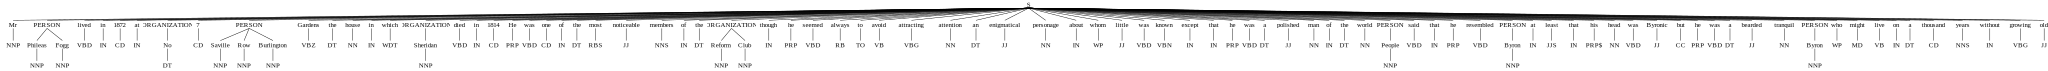

In [69]:
words=re.findall("\w+", document)
token=nltk.pos_tag(words)
chunk=nltk.ne_chunk(token)
chunk

In [70]:
[i for i in chunk if isinstance(i, nltk.Tree)] # first paragraph doesn't contain any GPEs ... 

[Tree('PERSON', [('Phileas', 'NNP'), ('Fogg', 'NNP')]),
 Tree('ORGANIZATION', [('No', 'DT')]),
 Tree('PERSON', [('Saville', 'NNP'), ('Row', 'NNP'), ('Burlington', 'NNP')]),
 Tree('ORGANIZATION', [('Sheridan', 'NNP')]),
 Tree('ORGANIZATION', [('Reform', 'NNP'), ('Club', 'NNP')]),
 Tree('PERSON', [('People', 'NNP')]),
 Tree('PERSON', [('Byron', 'NNP')]),
 Tree('PERSON', [('Byron', 'NNP')])]

In [71]:
city_candidates=list()
for i in chunk: 
    if isinstance(i, nltk.Tree):
        if i.label() == "GPE": 
            city_candidates.append([j[0] for j in i])

In [72]:
city_candidates #... but this logic extracts them 

[]

In [73]:
def preprocess(document): 
    
    global city_candidates
    
    words=re.findall("\w+", document)
    token=nltk.pos_tag(words)
    chunk=nltk.ne_chunk(token)
    
    for i in chunk: 
        if isinstance(i, nltk.Tree):
            if i.label() == "GPE": 
                city_candidates.append([j[0] for j in i])
    

In [74]:
for document in corpus: 
    preprocess(document)
    
city_candidates= set([" ".join(c) for c in city_candidates])

In [75]:
city_candidates

{'Aden',
 'Africa',
 'Ah',
 'Alas',
 'Allahabad',
 'America',
 'American',
 'Anam',
 'Aouda',
 'Arabic',
 'Armenian',
 'Articles',
 'Artisan',
 'Asia',
 'Asian',
 'Athens',
 'Barnum',
 'Behar',
 'Below',
 'Benares',
 'Bengal',
 'Between',
 'Bombay',
 'Book',
 'Bordeaux',
 'Brahma',
 'Brigham',
 'Brindisi',
 'British',
 'Broadway',
 'Buddhist',
 'Bundelcund',
 'Burn',
 'Buxar',
 'Calais',
 'Calcutta',
 'California',
 'Californian',
 'Calm',
 'Cambray',
 'Captain',
 'Cardiff',
 'Certain',
 'Chance',
 'Cheshire',
 'Chicago',
 'China',
 'China America',
 'Chinese',
 'Chupenie',
 'Colonel',
 'Colorado',
 'Colt',
 'Deal',
 'Dinner',
 'Dublin',
 'Dutch',
 'Dutchmen',
 'Egypt',
 'Egyptian',
 'Eighty',
 'Elephanta',
 'Eleven',
 'Enfield',
 'England',
 'England Norway',
 'English',
 'Europe',
 'European',
 'Europeans',
 'Fix',
 'Fogg',
 'France',
 'Fremont',
 'French',
 'Germany',
 'Good',
 'Gothic',
 'Great',
 'Greenwich',
 'Havre',
 'Heaven',
 'Himalaya',
 'Hindoo',
 'Holland',
 'Hong',
 'Hong

In [76]:
len(city_candidates)

200

Some of those candidates are non cities. Lets use the following logic to determine if the candidate is actually a city: 
 (a) Check its wiki page (as well as `name + " city"`, to account for, e.g., [New York](https://en.wikipedia.org/wiki/New_York))
 (b) Determine that it is a city if there is the `"cities"` pattern in the category section

In [77]:
import time

In [78]:
def check_for_city(city): 
    is_city = False
    
    time.sleep(0.05)
    r=s.get("https://en.wikipedia.org/wiki/" + city)
    html=fromstring(r.text)

    try: 
        categories=html.xpath('//div[@id="mw-normal-catlinks"]')[0].text_content()
    except: 
        categories=""
        
    if categories.find('cities') > 0: 
        is_city = True
    elif city.find("city") == -1: 
        is_city = check_for_city(city + " city")
    return is_city

In [79]:
check_for_city("Bordeaux")

True

In [80]:
check_for_city("New York")

True

In [81]:
check_for_city("Hong Kong")

True

In [82]:
check_for_city("France")

False

Very good. Now, for each city, return the coordinates on the top right. 

In [94]:
city = "Hong Kong"

r=s.get("https://en.wikipedia.org/wiki/" + city)
html=fromstring(r.text)

lat=html.xpath('//span[@class="latitude"]/text()')[0]
lat=re.sub("°", ".", lat)
lat=re.sub("′N|′S", "", lat)
lat=float(lat)

long=html.xpath('//span[@class="longitude"]/text()')[0]
long=re.sub("°", ".", long)
long=re.sub("′E|′W", "", long)
long=float(long)

lat, long

(22.18, 114.12)

In [93]:
lat, long

(22.18, 114.12)

In [151]:
def get_coord(city): 
    print(city)
    is_city = False
    
    time.sleep(0.05)
    r=s.get("https://en.wikipedia.org/wiki/" + city)
    html=fromstring(r.text)

    try: 
        categories=html.xpath('//div[@id="mw-normal-catlinks"]')[0].text_content()
    except: 
        categories=""
        
    if categories.find('cities') > 0: 
        is_city = True
    elif city.find("city") == -1: 
        is_city = get_coord(city + " city")
        if not isinstance(is_city, bool): # return coord if there are any
            return is_city
        
    if is_city: 
        try: 
            lat_string=html.xpath('//span[@class="latitude"]/text()')[0]
            lat=re.findall('\d*', lat_string)
            lat=float(lat[0] + '.' + lat[2]) 
            if re.search('S', lat_string): 
                lat = -lat

            long_string=html.xpath('//span[@class="longitude"]/text()')[0]
            long=re.findall('\d*', long_string)
            long=float(long[0] + '.' + long[2]) 
            if re.search('W', long_string): 
                long = -long

            return lat, long
        except: 
            is_city = False
    
    return is_city

In [152]:
get_coord("Bordeaux")

Bordeaux


(44.5, -0.35)

In [153]:
get_coord("New York")

New York
New York city


(40.42, -74.0)

Put all in a pipeline and run! 

In [154]:
coord = {city: get_coord(city) for city in city_candidates}

Benares
Silence
Silence city
Colonel
Colonel city
San
San city
Asia
Asia city
Well
Well city
Burn
Burn city
Articles
Articles city
Nevada
Nevada city
Scotland Yard
Scotland Yard city
Good
Good city
Middle
Middle city
Mexico
Mexico city
Phileas Fogg
Phileas Fogg city
Vast
Vast city
European
European city
Salcette
Salcette city
Pillaji
Pillaji city
Dinner
Dinner city
Bombay
Eleven
Eleven city
Calcutta
Little
Little city
Heaven
Heaven city
Observe
Observe city
New Jersey
New Jersey city
Victoria
Victoria city
Quite
Quite city
Europe
Europe city
Mormon
Mormon city
Captain
Captain city
Liverpool
Greenwich
Greenwich city
America
America city
Germany
Germany city
Eighty
Eighty city
Ohio
Ohio city
Jean
Jean city
Asian
Asian city
Israel
Israel city
Fremont
Fremont city
Wyoming
Wyoming city
American
American city
Wait
Wait city
France
France city
Certain
Certain city
Africa
Africa city
Dutch
Dutch city
Stop
Stop city
Uranus
Uranus city
Cambray
Cambray city
Athens
Athens city
Kholby
Kholby city
C

In [158]:
cd = {k: v for k, v in coord.items() if v is not False} 

In [180]:
import pandas as pd

df = pd.DataFrame(cd).T
df=df.reset_index()

df = df.rename(columns={'index': 'Name', 0: 'latitude', 1: 'longitude'})

In [181]:
import plotly.express as px
import geopandas as gpd

px.set_mapbox_access_token(open("./../keys/mapbox.txt").read())
fig = px.scatter_mapbox(df,
                        lat='latitude',
                        lon='longitude',
                        hover_name="Name",
                        zoom=4)
fig.show()